# Clustering and visualizing the `penguins` dataset in 2D with *Self-Organizing Map*

In [01_kmeans_clustering.ipynb](./01_kmeans_clustering.ipynb) we use/used the `K-Means` algorithm to find groups of data points. In [02_som_representation_learning.ipynb](./02_som_representation_learning.ipynb) we use *Self-Organizing Map* to learn the representation of the dataset.

Here we want to find the optimal SOM hyperparameter combination that fits the data closely while the map still remaining organized.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

RAND = 42

## Dataset

In [2]:
X_scaled = pd.read_csv("../datasets/penguins/simple/X_scaled.csv", index_col=0, header=0)
X_scaled_idx = X_scaled.index
X_scaled = X_scaled.to_numpy()
y = pd.read_csv("../datasets/penguins/simple/y.csv", index_col=0, header=0)

## Representation learning

In [3]:
from _utilities.som import calc_recommended_grid_size, train_som

In [4]:
print("Recommended grid size:", calc_recommended_grid_size(X_scaled))

Recommended grid size: (np.float64(92.46621004453465), 10)


In [5]:
best_pos = [34.96891501, 84.04996842, 0.83596097]

In [6]:
# hyperparameter optimization

import pyswarms as ps

def single_trial(p):
	SOM_DIM = int(p[0])
	SOM_SIGMA = np.round(SOM_DIM / 3)
	SOM_NUM_ITERATION = int(p[1])
	SOM_LEARNING_RATE = p[2]

	hyparams = {
		"d1": SOM_DIM,
		"d2": SOM_DIM,
		"sigma": SOM_SIGMA,
		"learning_rate": SOM_LEARNING_RATE,
		"num_iteration": SOM_NUM_ITERATION,
		"topology": "rectangular"
	}

	som = train_som(X=X_scaled, **hyparams, random_seed=RAND, verb=False)
	return som.quantization_error(X_scaled)

def objective(params):
    return np.array([single_trial(p) for p in params])

bounds = (np.array([30, 2, 0.5]),  # min d, min epochs, min lr
          np.array([40, 100, 1]))  # max d, max epochs, max lr

options = {'c1': 1.5, 'c2': 1.5, 'w': 0.5}
optimizer = ps.single.GlobalBestPSO(n_particles=20, dimensions=3, options=options, bounds=bounds)

if best_pos is None:
	best_cost, best_pos = optimizer.optimize(objective, iters=5)

	print("Optimal hyperparameters:", best_pos)
	print("Best score:", best_cost)

In [7]:
SOM_DIM = int(best_pos[0])
SOM_SIGMA = np.round(SOM_DIM / 3)
SOM_NUM_ITERATION = int(best_pos[1])
SOM_LEARNING_RATE = best_pos[2]

hyparams = {
    "d1": SOM_DIM,
    "d2": SOM_DIM,
    "sigma": SOM_SIGMA,
    "learning_rate": SOM_LEARNING_RATE,
    "num_iteration": SOM_NUM_ITERATION,
    "topology": "rectangular"
}

som = train_som(X=X_scaled, **hyparams, random_seed=RAND, verb=True)

node_weights = som.get_weights()
node_weights_flat = node_weights.reshape(-1, node_weights.shape[2])
activation_map = som.activation_response(X_scaled)
activations_flat = activation_map.flatten()

assert som.topographic_error(X_scaled) < .1, "The SOM is not organized!"

 [ 28728 / 28728 ] 100% - 0:00:00 left 
 quantization error: 0.4009905925990448

Brief quality of SOM:
Quantization error:	0.401
Topographic error:	0.009
Topographic error (VN):	0.099


In [8]:
# PCA

from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(X_scaled)

X_scaled_pca = pca.transform(X_scaled)
node_weights_flat_pca = pca.transform(node_weights_flat)

print("PCA features explained variance:", np.round(np.sum(pca.explained_variance_ratio_), 2))

PCA features explained variance: 0.97


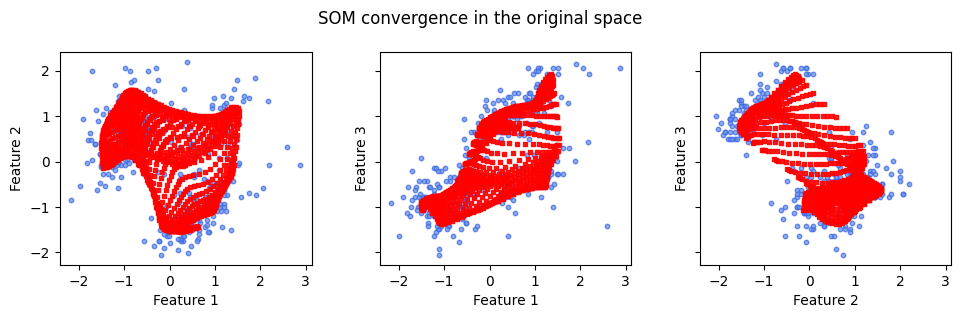

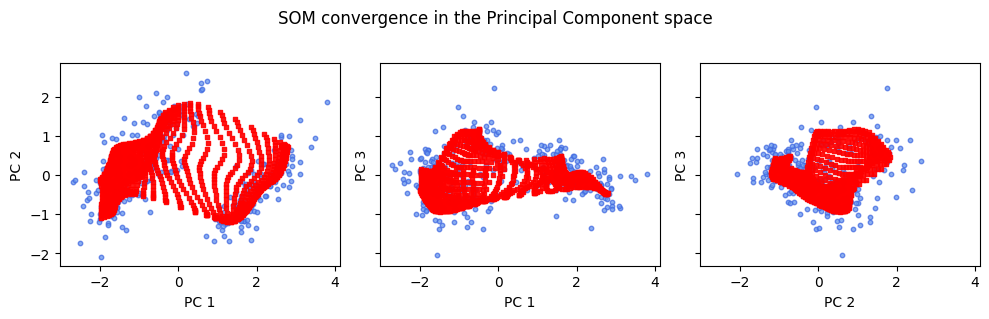

In [9]:
from _utilities.som_plot import visualize_distance_map, visualize_hitmap, plot_3_feature, plot_in_3PC

plot_3_feature(X_scaled, node_weights_flat, axis_label="Feature", figsize=(10, 3), title="SOM convergence in the original space")
plot_3_feature(X_scaled_pca, node_weights_flat_pca, axis_label="PC", figsize=(10, 3), title="SOM convergence in the Principal Component space")

In [10]:
plot_in_3PC(X_scaled_pca, nw_shape=node_weights.shape, nw_flat=node_weights_flat_pca)

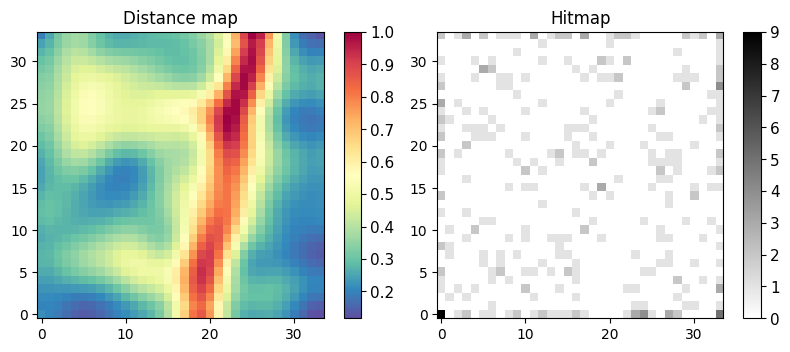

In [11]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 4))

visualize_distance_map(som=som, X=X_scaled, ax=ax0)
visualize_hitmap(som=som, X=X_scaled, ax=ax1)

plt.tight_layout()         
plt.show()

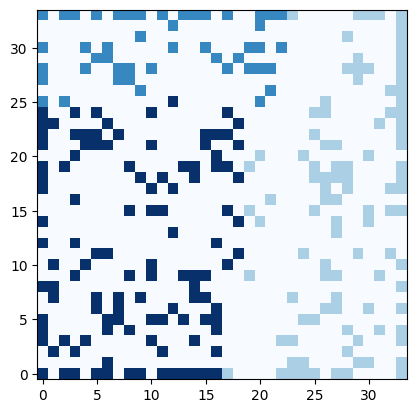

In [12]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(n_clusters=3, linkage="average")
clustering.fit(node_weights_flat)

clustering_map = clustering.labels_.reshape(activation_map.shape)
clustering_map[activation_map == 0] = -1

plt.imshow(clustering_map, origin="lower", cmap="Blues")

In [13]:
# make clustering predictions and export

y_pred = np.array([clustering_map[som.winner(x)] for x in X_scaled])

df_pred = pd.DataFrame(y_pred, index=X_scaled_idx, columns=['cluster_id'])
df_pred.to_csv("predictions/03_som_clustering_predictions.csv")